# Question 2: DH algorithm (50 points)
In this question we are going to implmeneted the DH algorithm according to this paper:https://icml.cc/Conferences/2008/papers/324.pdf, in which we try to predict protein localization sites in Eukaryotic cells.

In [1]:
import copy
import warnings
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import choice
from scipy.cluster.hierarchy import linkage
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
seed = 2021
warnings. filterwarnings("ignore")

## 2.0 Data loading and hierarchical clustering
DH algorithm is based on hierarchical clustering of the dataset, we will use the DH algorithm on this classification problem: [Protein Localization Prediction](https://archive.ics.uci.edu/ml/datasets/Yeast), the first step is to load the dataset and conduct a hierarchical clustring using the **Scipy** package. *This part has been implemented, read through the code to make sure you understand what is being done.*

In [2]:
def load_data(seed = 2021):
    """ Loads "Protein Localizataion Prediction" data. Computes linkage from hierarchical clustering.
    :returns X_train: data matrix 538x8
    :returns Y_train: true labels 538x1
    :returns X_test: data matrix 135x8
    :returns Y_test: true labels 135x1
    :returns T: 3 element tree
        T[0] = linkage matrix from hierarchical clustering.  See https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
               for details. If you are unfamiliar with hierarchical clustering using scipy, the following is another helpful resource (We won't use dendrograms
               here, but he gives a nice explanation of how to interpret the linkage matrix):
               https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/ 

        T[1] = An array denoting the size of each subtree rooted at node i, where i indexes the array.  
               ie. The number of all leaves in subtree rooted at node i (w_i in the paper).

        T[2] = dict where keys are nodes and values are the node's parent
        """
    df = pd.read_csv('./data/data.csv')
    np.unique(df.Label,return_counts = True)
    filter_class = ['MIT','NUC']
    mask = df.Label ==0
    for x in filter_class:
        mask = mask | (df.Label==x)
    df = df[mask]
    X = df.iloc[:,:8].to_numpy()
    y = df.Label.astype('category').cat.codes.to_numpy()
    X, X_test, y, y_test = train_test_split(X,y,test_size = 0.2, random_state = seed)
    n_samples = len(X)
    Z = linkage(X,method='ward')
    link = Z[:,:2].astype(int)
    subtree_sizes = np.zeros(link[-1,-1]+2)
    subtree_sizes[:n_samples] = 1
    parent = {}
    parent[2*(n_samples-1)] = -1 #set root node as 0
    for i in range(len(link)):
        left = link[i,0]
        right = link[i,1]
        current = i + n_samples
        subtree_sizes[current] = subtree_sizes[left] + subtree_sizes[right] 
        parent[left] = current
        parent[right] = current

    T = [link,subtree_sizes,parent]

    return X.astype("float"), y, X_test, y_test, T 

X_train, y_train, X_test, y_test, T = load_data()

# 2.0.1 Supervised classification methods.
Following we provide several classifiers that can be used, choose your favourite one. To use the Neural Network classifier, you need to install [pytorch](https://pytorch.org/).

In [3]:
## Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)

## Random Forest
N_estimator_rf = 20
MAX_depth_rf = 6
rf = RandomForestClassifier(n_estimators = N_estimator_rf, 
                            max_depth = MAX_depth_rf, random_state = seed)
rf.fit(X_train, y_train)

## Gradient Boosting Decision Tree
N_estimator_gbdt = 20
gbdt_max_depth = 6
gbdt = GradientBoostingClassifier(n_estimators = N_estimator_gbdt,
                                 learning_rate = 0.1,
                                 max_depth = gbdt_max_depth,
                                 random_state = seed)
gbdt.fit(X_train,y_train)

## 3-Layer fully connected NN
import torch
from torch.utils.data import Dataset
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
torch.manual_seed(seed)
class NNClassifier(object):
    def __init__(self,
                 feature_n,
                 class_n,
                 hidden_n = 30,
                 learning_rate = 4e-3,
                 weight_decay = 1e-5):
        self.model = torch.nn.Sequential(torch.nn.Linear(feature_n,hidden_n),
                                        torch.nn.SiLU(),
                                        torch.nn.Linear(hidden_n,hidden_n),
                                        torch.nn.SiLU(),
                                        torch.nn.Linear(hidden_n,class_n))
        self.lr = learning_rate
        self.wd = weight_decay
    def fit(self,X_train,y_train,epoches = 300,batch_size = 50):
        X_t = torch.from_numpy(X_train.astype(np.float32))
        y_t = torch.from_numpy(y_train.astype(np.int64))
        dataset = TensorDataset(X_t,y_t)
        loader = DataLoader(dataset,batch_size = batch_size,shuffle = True)
        loss_fn = torch.nn.CrossEntropyLoss(reduction = 'mean')
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr,weight_decay=self.wd)
        loss_record = 0.0
        report_epoch = 50
        for epoch_i in range(epoches):
            for batch in loader:
                x_batch,y_batch = batch
                y_pred = self.model(x_batch)
                loss = loss_fn(y_pred,y_batch)
                self.model.zero_grad()
                loss.backward()
                optimizer.step()
                loss_record += loss.item()
            if epoch_i%report_epoch == report_epoch-1:
                print("[%d|%d] epoch loss:%.2f"%(epoch_i+1,epoches,loss_record/report_epoch))
                loss_record = 0.0
            if epoch_i>=epoches:
                break
    
    def score(self,X_test,y_test):
        X_test_tensor = torch.from_numpy(X_test.astype(np.float32))
        y_pred_test = self.model(X_test_tensor)
        y_output = torch.argmax(y_pred_test,axis = 1).numpy()
        return (y_output == y_test).mean()
        
nn = NNClassifier(feature_n = X_train.shape[1],class_n = len(np.unique(y_train)))
nn.fit(X_train,y_train)

## Accuracy of 4 classifiers.
print('Accuracy of logistic regression: \t{:.3f}'.format(lr.score(X_test,y_test)))
print('Accuracy of random forest: \t\t{:.3f}'.format(rf.score(X_test,y_test)))
print('Accuracy of Gradient Boosting Decision Tree: \t\t{:.3f}'.format(gbdt.score(X_test,y_test)))
print('Accuracy of Neural Network: \t\t{:.3f}'.format(nn.score(X_test,y_test)))

[50|300] epoch loss:4.70
[100|300] epoch loss:4.36
[150|300] epoch loss:4.32
[200|300] epoch loss:4.29
[250|300] epoch loss:4.26
[300|300] epoch loss:4.25
Accuracy of logistic regression: 	0.874
Accuracy of random forest: 		0.896
Accuracy of Gradient Boosting Decision Tree: 		0.867
Accuracy of Neural Network: 		0.889


### Choose and initialize your classifier:
The classifier is going to be used in 2.2, the choose of classifier won't influence your grade

In [4]:
#TODO: Uncomment one line to choose your classifier.
# classifier = LogisticRegression()

#classifier = RandomForestClassifier(n_estimators = N_estimator_rf,max_depth = MAX_depth_rf, random_state = seed)

# classifier = GradientBoostingClassifier(n_estimators = N_estimator_gbdt,
#                                 learning_rate = 0.1,
#                                 max_depth = gbdt_max_depth,
#                                 random_state = seed)

classifier = NNClassifier(feature_n = X_train.shape[1],class_n = len(np.unique(y_train)))


## 2.1 Implement the DH algorithm (Hierarchical Sampling for Active Learning). (30 points)
Please complete the functions to implement the DH algorithm and run the active learning algorithm on the training dataset. The utils functions has been implemented and attached in the homework folder, including **update_empirical.py, best_pruning_and_labeling.py, assign_labels.py and get_leaves.py**, please read them and finish the following functions to implement the DH algorithm.

In [5]:
from update_empirical import update_empirical
from best_pruning_and_labeling import best_pruning_and_labeling
from assign_labels import assign_labels
from get_leaves import get_leaves

In [6]:
def compute_error(L,labels):
    """Compute the error

    :param L: labeling of leaf nodes
    :param labels: true labels of each node

    :returns error: error of predictions"""

    wrong = 0
    wrong = (L[:len(labels)]!=labels).sum()
    error = wrong/len(labels)
    return error

def select_case_1(data,labels,T,budget,batch_size):
    """DH algorithm where we choose P proportional to the size of subtree rooted at each node

    :param data: Data matrix 1200x8
    :param labels: true labels 1200x1
    :param T: 3 element tree
        T[0] = linkage matrix from hierarchical clustering.  See https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
               for details. If you are unfamiliar with hierarchical clustering using scipy, the following is another helpful resource (We won't use dendrograms
               here, but he gives a nice explanation of how to interpret the linkage matrix):
               https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/ 

        T[1] = An array denoting the size of each subtree rooted at node i, where i indexes the array.  
               i.e. The number of all children + grandchildren + ... + the node itself

        T[2] = dict where keys are nodes and values are the node's parent
    :param budget: Number of iterations to make 
    :param batch_size: Number of queries per iteration"""

    n_nodes = len(T[1]) #total nodes in T
    n_samples = len(data) #total samples in data
    L = np.zeros(n_nodes) #majority label
    p1 = np.zeros(n_nodes) #empirical label frequency
    n = np.zeros(n_nodes) #number of points sampled from each node
    error = []#np.zeros(n_samples) #error at each round
    root = n_nodes-1 #corresponds to index of root
    P = np.array([root])
    L[root] = 1    
    
    for i in range(budget):
        selected_P = []
        for b in range(batch_size):
            #TODO: select a node from P proportional to the size of subtree rooted at each node
            node = P.reshape(-1)
            size = np.array([len(get_leaves([], i, T, n_samples)) for i in node])
            total_size = size.sum()
            prob = size / total_size
            v = np.random.choice(node, 1, p=prob)
            selected_P.append(v)
            leaves = get_leaves([], v, T, n_samples)
            
            ##TODO: pick a random leaf node from subtree Tv and query its label
            query_idx = np.random.randint(0,len(leaves))
            z = leaves[query_idx]
            l = labels[z]
            #TODO: update empirical counts and probabilities for all nodes u on path from z to v
            n, p1 = update_empirical(n,p1,v,z,l,T)
        
        for p in selected_P:
            #TODO: update admissible A and compute scores; find best pruning and labeling
            P_best, L_best = best_pruning_and_labeling(n,p1,p,T,n_samples)            
            #TODO: update pruning P and labeling L
            P = np.delete(P, np.where(P == p))
            P = np.hstack((P, P_best.reshape(-1)))
            L[p] = L_best
            L = assign_labels(L,p,p,T,n_samples)
            
        #TODO: temporarily assign labels to every leaf and compute error
        L_temp = L.copy()
        P = np.array(list(set(P)))
        for i in range(len(P)):
            L_temp = assign_labels(L_temp,P[i],P[i],T,n_samples)
        err = compute_error(L_temp,labels)
        error.append(err)

    for i in range(len(P)):
        L = assign_labels(L,P[i],P[i],T,n_samples)
    
    return L, np.array(error)

def select_case_2(data,labels,T,budget,batch_size):
    """DH algorithm where we choose P by biasing towards choosing nodes in areas where the observed labels are less pure

    :param data: Data matrix 1200x8
    :param labels: true labels 284x1
    :param T: 3 element tree
        T[0] = linkage matrix from hierarchical clustering.  See https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
               for details. If you are unfamiliar with hierarchical clustering using scipy, the following is another helpful resource (We won't use dendrograms
               here, but he gives a nice explanation of how to interpret the linkage matrix):
               https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/ 

        T[1] = An array denoting the size of each subtree rooted at node i, where i indexes the array.  
               ie. The number of all children + grandchildren + ... + the node itself

        T[2] = dict where keys are nodes and values are the node's parent
    :param budget: Number of iterations to make 
    :param batch_size: Number of queries per iteration"""

    n_nodes = len(T[1]) #total nodes in T
    n_samples = len(data) #total samples in data
    L = np.zeros(n_nodes,dtype = int) #majority label
    p1 = np.zeros(n_nodes) #empirical label frequency
    n = np.zeros(n_nodes) #number of points sampled from each node
    error = []#np.zeros(n_samples) #error at each round
    root = n_nodes-1 #corresponds to index of root
    P = np.array([root])
    L[root] = 1    
    
    def lb(p_node, n_node):
        if n_node == 0:
            return 0
        return p_node - ((1/n_node) + np.sqrt(p_node*(1-p_node)/n_node))
    
    for i in range(budget):
        selected_P = []
        for b in range(batch_size):
            #TODO: select a node from P biasing towards choosing nodes in areas where the observed labels are less pure
            node = P.reshape(-1)
            weight = np.array([len(get_leaves([], i, T, n_samples)) * (1-lb(p1[i], n[i])) for i in node])
            prob = weight / weight.sum()
            v = np.random.choice(node, 1, p=prob)
            selected_P.append(v)
            leaves = get_leaves([], v, T, n_samples)
            
            ##TODO: pick a random leaf node from subtree Tv and query its label
            query_idx = np.random.randint(0,len(leaves))
            z = leaves[query_idx]
            l = labels[z]
            
            #TODO: update empirical counts and probabilities for all nodes u on path from z to v
            n, p1 = update_empirical(n,p1,v,z,l,T)
        for p in selected_P:
            #TODO: update admissible A and compute scores; find best pruning and labeling
            P_best, L_best = best_pruning_and_labeling(n,p1,p,T,n_samples)            
            #TODO: update pruning P and labeling L
            P = np.delete(P, np.where(P == p))
            P = np.hstack((P, P_best.reshape(-1)))
            L[p] = L_best
            L = assign_labels(L,p,p,T,n_samples)

        #TODO: temporarily assign labels to every leaf and compute error
        L_temp = L.copy()
        P = np.array(list(set(P)))
        for i in range(len(P)):
            L_temp = assign_labels(L_temp,P[i],P[i],T,n_samples)
        err = compute_error(L_temp,labels)
        error.append(err)
        
    for i in range(len(P)):
        L = assign_labels(L,P[i],P[i],T,n_samples)
        
    return L, np.array(error)                


## 2.2 Run the sample code (10 points)
Run the following sample code and compare the two figures.

Running part B
Currently on iteration 0
[50|300] epoch loss:5.28
[100|300] epoch loss:5.02
[150|300] epoch loss:4.96
[200|300] epoch loss:4.90
[250|300] epoch loss:4.91
[300|300] epoch loss:4.87
Accuracy of classifier trained on random sampling dataset: 	0.881
Running part C
Currently on iteration 0
[50|300] epoch loss:5.81
[100|300] epoch loss:5.74
[150|300] epoch loss:5.64
[200|300] epoch loss:5.53
[250|300] epoch loss:5.40
[300|300] epoch loss:5.30
Accuracy of classifier trained on active learning dataset: 	0.837


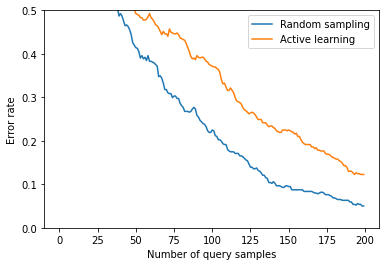

In [7]:
def call_DH(part,clf,budget):
    """Main function to run all your code once complete.  After you complete
       select_case_1() and select_case_2(), this will run the DH algo for each 
       dataset and generate the plots you will submit within your write-up.

       :param part: which part of the homework to run
       :param clf: The classifier used to predcit on the dataset.
       :param budget: The number of times that one can query a label from the oracle.
    """
    
    part = part.lower()
    num_trials = 1
    batch_size = 10
    clf2 = copy.deepcopy(clf)
    axs = plt.subplot()
    if part == "b":
        print("Running part B")
        X_train, y_train, X_test, y_test, T = load_data()
        l = np.zeros(budget)
        for i in range(num_trials):
            print("Currently on iteration {}".format(i))
            L, error = select_case_1(X_train,y_train,T,budget,batch_size)
            l += error 
        l /= num_trials
        
        ## TODO: train the classifier clf on the predicted label.
        #raise(NotImplementedError)
        clf.fit(X_train,L[:len(X_train)])
        
        print('Accuracy of classifier trained on random sampling dataset: \t{:.3f}'.format(clf.score(X_test,y_test)))
        axs.plot(np.arange(budget),l,label = "Random sampling")

    elif part == "c":
        print("Running part C")
        X_train, y_train, X_test, y_test, T = load_data()
        l = np.zeros(budget)
        for i in range(num_trials):
            print("Currently on iteration {}".format(i))
            L, error = select_case_2(X_train,y_train,T,budget,batch_size)
            l += error 
        l /= num_trials
        
        ## TODO: train the classifier clf2 on the predicted label.
        #raise(NotImplementedError)
        clf2.fit(X_train,L[:len(X_train)])
        
        print('Accuracy of classifier trained on active learning dataset: \t{:.3f}'.format(clf2.score(X_test,y_test)))
        axs.plot(np.arange(budget),l,label = "Active learning")

    else:
        print("Incorrect part provided. Either 'b', 'c', 'd', or 'e' expected")
    axs.set_ylim([0,0.5])
    axs.set_xlabel("Number of query samples")
    axs.set_ylabel("Error rate")
    plt.legend()
    plt.savefig("q2_2.png")
BUDGET = 200 #You can change this number to a smaller one during testing.
for part in "bc":
    call_DH(part,classifier,BUDGET)


## 2.3 Questions (10 points):
### What is a "admissible pair" according to the paper (5 points)?
### Please explain the sampling bias that is dealt with in the DH algorithm and why it would be a problem if we just query the unlabeled point which is closest to the decision boundary (5 points)?